In [63]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import galsim
from generate_data_new import get_LSST_PSF

%matplotlib inline

In [64]:
COSMOS_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/'
# real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample=str(23.5))
real_galaxy_catalog = galsim.RealGalaxyCatalog(sample=str(23.5))

fov_pixels = 12
pixel_scale = 0.2
upsample = 4

In [65]:
random_seed = 31415 # randomly choose a seed for the rng
rng_base = galsim.BaseDeviate(seed=random_seed)
rng = galsim.UniformDeviate(seed=random_seed) # U(0,1).
rng_defocus = galsim.GaussianDeviate(rng_base, mean=0., sigma=0.36) # N(0,0.36).
rng_gaussian = galsim.GaussianDeviate(rng_base, mean=0., sigma=0.07) # N(0,0.07).

fwhms = np.array([0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
freqs = np.array([0., 20., 17., 13., 9., 0.])
fwhm_table = galsim.LookupTable(x=fwhms, f=freqs, interpolant='spline')
fwhms = np.linspace(fwhms[0],fwhms[-1],100) # Upsample the distribution.
freqs = np.array([fwhm_table(fwhm) for fwhm in fwhms]) / fwhm_table.integrate() # Normalization.
rng_fwhm = galsim.DistDeviate(seed=rng_base, function=galsim.LookupTable(x=fwhms, f=freqs, interpolant='spline'))

# Atmospheric PSF
atmos_fwhm = rng_fwhm()             # Atmospheric seeing (arcsec), the FWHM of the Kolmogorov function.
atmos_e = 0.01 + 0.02 * rng()       # Ellipticity of atmospheric PSF (magnitude of the shear in the “distortion” definition), U(0.01, 0.03).
atmos_beta = 2. * np.pi * rng()     # Shear position angle (radians), N(0,2*pi).

# Optical PSF
opt_defocus = rng_defocus()         # Defocus (wavelength), N(0.0.36).
opt_a1 = rng_gaussian()             # Astigmatism (like e2) (wavelength), N(0.0.07).
opt_a2 = rng_gaussian()             # Astigmatism (like e1) (wavelength), N(0.0.07).
opt_c1 = rng_gaussian()             # Coma along y axis (wavelength), N(0.0.07).
opt_c2 = rng_gaussian()             # Coma along x axis (wavelength), N(0.0.07).
spher = rng_gaussian()              # Spherical aberration (wavelength), N(0.0.07).
trefoil1 = rng_gaussian()           # Trefoil along y axis (wavelength), N(0.0.07).
trefoil2 = rng_gaussian()           # Trefoil along x axis (wavelength), N(0.0.07).
opt_obscuration = 0.1 + 0.4 * rng() # Linear dimension of central obscuration as fraction of pupil linear dimension, U(0.1, 0.5).
lam_over_diam = .017 + 0.007 * rng() # Wavelength over diameter (arcsec), U(0.013, 0.083).

### FWHM Error

In [66]:
fwhm_errs = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
noisy_psfs = []

for fwhm_err in fwhm_errs:
    noisy_psfs.append(get_LSST_PSF(lam_over_diam, opt_defocus, opt_c1, opt_c2, opt_a1, opt_a2, opt_obscuration,
                                   atmos_fwhm+fwhm_err, atmos_e, atmos_beta, spher, trefoil1, trefoil2,
                                   0, 0,
                                   fov_pixels, pixel_scale, upsample))

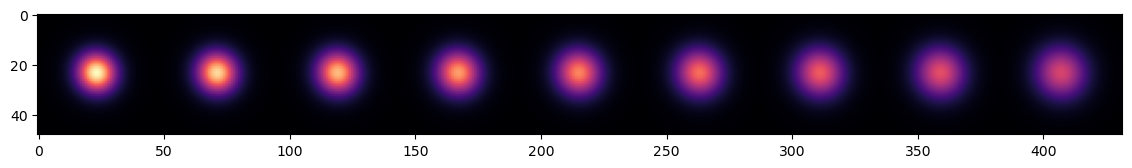

In [67]:
img = np.zeros([fov_pixels*upsample, fov_pixels*upsample*len(fwhm_errs)])
for idx, psf in enumerate(noisy_psfs):
    img[:,fov_pixels*upsample*idx:fov_pixels*upsample*(idx+1)] = psf
    
plt.figure(figsize=(14,3))
plt.imshow(img, cmap='magma')
plt.imsave('cartoon_seeing.png', img, cmap='magma')

### Shear Error

In [68]:
shear_errs = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
noisy_psfs = []

for shear_err in shear_errs:
    noisy_psfs.append(get_LSST_PSF(lam_over_diam, opt_defocus, opt_c1, opt_c2, opt_a1, opt_a2, opt_obscuration,
                                   atmos_fwhm, atmos_e, atmos_beta, spher, trefoil1, trefoil2,
                                   shear_err, shear_err,
                                   fov_pixels, pixel_scale, upsample))

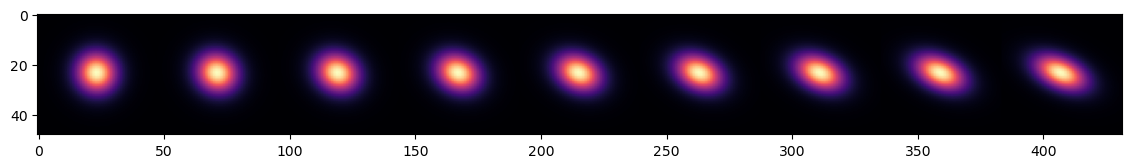

In [69]:
img = np.zeros([fov_pixels*upsample, fov_pixels*upsample*len(shear_errs)])
for idx, psf in enumerate(noisy_psfs):
    img[:,fov_pixels*upsample*idx:fov_pixels*upsample*(idx+1)] = psf
    
plt.figure(figsize=(14,3))
plt.imshow(img, cmap='magma')
plt.imsave('cartoon_shear.png', img, cmap='magma')